In [280]:
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import root_mean_squared_error as rmse

## Loading data

In [281]:
DATA_PATH = '/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Forecasting-water-inflow/Data loading and handling/Cleaned data etc./data_cleaned_and_interpolated.csv'

# Adjust these column names as needed.
date_col = 'time'
target_col = 'KarupBro'
# List of meteorological features from DMI – update if needed.
input_cols = [
    'temp_min_daily', 'temp_max_daily', 'temp_mean_daily', 
    'temp_grass_mean_daily', 'temp_soil_min_daily', 'temp_soil_max_daily', 
    'temp_soil_mean_daily', 'humidity_daily', 'wind_direction_daily', 
    'wind_speed_daily', 'wind_gust_max_daily', 'precip_total_daily', 
    'precip_duration_daily', 'radiation_global_daily', 
    'sunshine_duration_daily'
]


# Read the CSV
df = pd.read_csv(DATA_PATH, parse_dates=[date_col])
df.sort_values(date_col, inplace=True)
df.reset_index(drop=True, inplace=True)

# Optional: Set the date column as index (if needed)
df.set_index(date_col, inplace=True)

df.tail()

,temp_min_daily,temp_max_daily,temp_mean_daily,temp_grass_mean_daily,temp_soil_min_daily,temp_soil_max_daily,temp_soil_mean_daily,humidity_daily,wind_direction_daily,wind_gust_max_daily,wind_speed_daily,precip_total_daily,precip_duration_daily,radiation_global_daily,sunshine_duration_daily,KarupBro
time,,,,,,,,,,,,,,,,
2023-12-20,0.8,4.4,3.141667,2.316667,5.1,5.4,5.241667,88.583333,252.000000,12.2,2.541667,0.4,4.0,349.0,111.0,4448.18
2023-12-21,1.4,8.7,5.316667,4.637500,5.0,5.3,5.141667,86.083333,254.666667,22.5,5.329167,19.9,159.0,270.0,29.5,5602.14
2023-12-22,0.1,4.0,2.395833,1.129167,4.0,5.1,4.533333,66.000000,293.416667,19.1,5.020833,0.6,3.0,749.0,294.5,6636.60
2023-12-23,-1.6,3.3,0.833333,-0.250000,3.6,4.1,3.754167,88.000000,264.000000,10.5,2.379167,0.8,4.0,589.0,247.0,5809.15
2023-12-24,-0.3,2.1,1.120000,0.700000,3.4,3.6,3.520000,97.700000,136.500000,6.6,1.500000,5.0,38.0,9.0,0.0,5197.78


In [282]:
# Check for missing values
df.isnull().sum()

temp_min_daily             0
temp_max_daily             0
temp_mean_daily            0
temp_grass_mean_daily      0
temp_soil_min_daily        0
temp_soil_max_daily        0
temp_soil_mean_daily       0
humidity_daily             0
wind_direction_daily       0
wind_gust_max_daily        0
wind_speed_daily           0
precip_total_daily         0
precip_duration_daily      0
radiation_global_daily     0
sunshine_duration_daily    0
KarupBro                   0
dtype: int64

<Figure size 1200x1200 with 0 Axes>

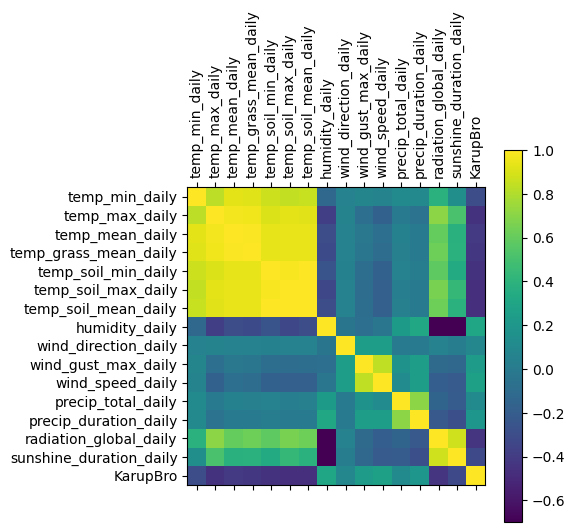

In [283]:
# Correlation matrix
corr = df.corr()
plt.figure(figsize=(12, 12))
plt.matshow(corr, fignum=2)
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.show()

## Filtering data to simple model

In [284]:
df_simple = df[["temp_mean_daily", "precip_total_daily", "KarupBro"]]
df_simple.head()

,temp_mean_daily,precip_total_daily,KarupBro
time,,,
2002-01-01,1.250000,2.2,1829.75
2002-01-02,-0.837500,0.0,7279.46
2002-01-03,-5.166667,0.0,5261.85
2002-01-04,-6.025000,0.0,2951.97
2002-01-05,-3.466667,0.1,1868.53


<Axes: xlabel='time'>

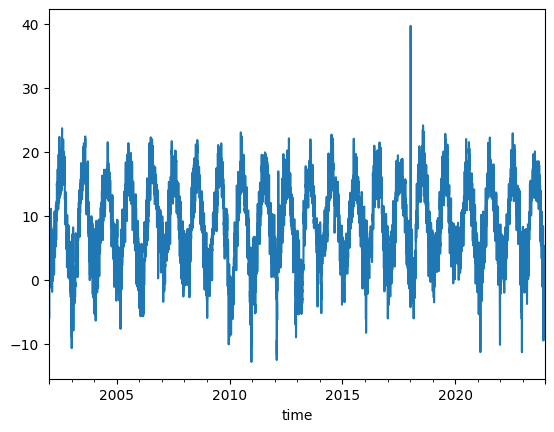

In [285]:
temp = df['temp_mean_daily']
temp.plot()

In [286]:
# Replace outliers with NaN
df.loc[df["temp_mean_daily"] > 35, "temp_mean_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["temp_mean_daily"] = df["temp_mean_daily"].ffill()

<Axes: xlabel='time'>

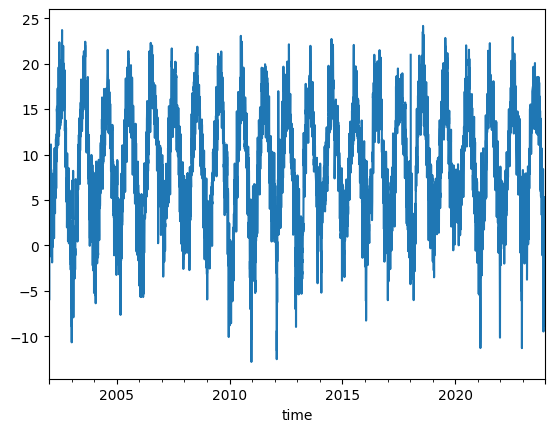

In [287]:
temp.plot()

<Axes: xlabel='time'>

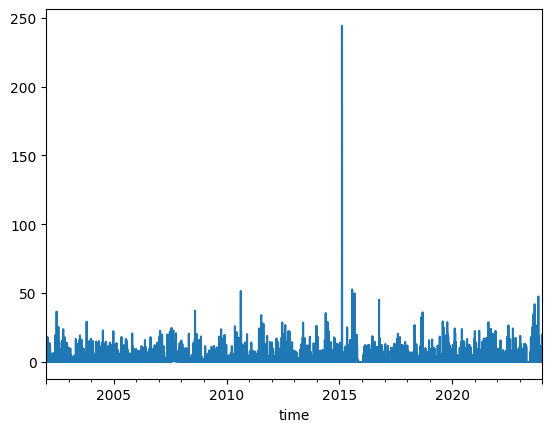

In [288]:
rain = df['precip_total_daily']
rain.plot()

In [289]:
import numpy as np

# Replace outliers with NaN
df.loc[df["precip_total_daily"] > 100, "precip_total_daily"] = np.nan

# Forward-fill (ffill) the missing values
df["precip_total_daily"] = df["precip_total_daily"].ffill()

<Axes: xlabel='time'>

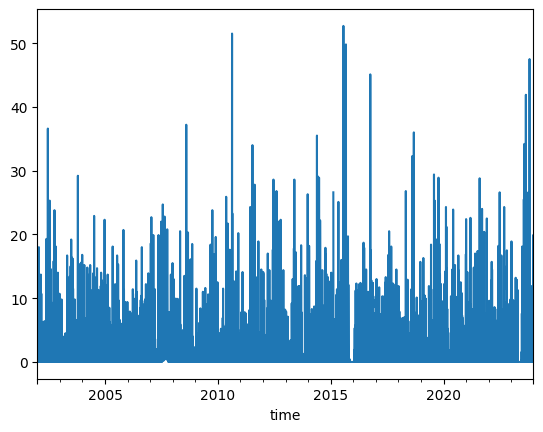

In [290]:
rain.plot()

<Axes: xlabel='time'>

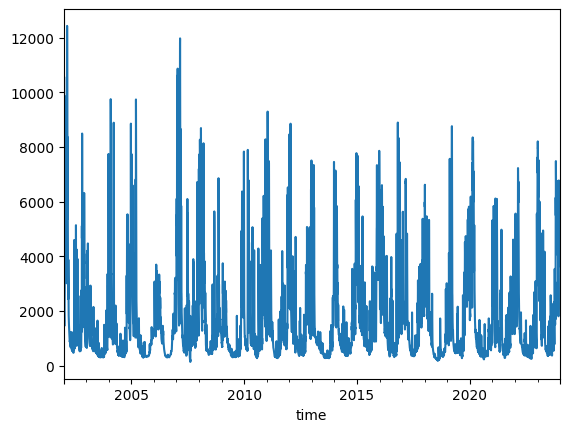

In [291]:
inflow = df['KarupBro']
inflow.plot()

## Multi-variable

In [292]:
inflow_df = pd.DataFrame({'Inflow':inflow})
inflow_df['Seconds'] = inflow_df.index.map(pd.Timestamp.timestamp)
inflow_df

,Inflow,Seconds
time,,
2002-01-01,1829.75,1.009843e+09
2002-01-02,7279.46,1.009930e+09
2002-01-03,5261.85,1.010016e+09
2002-01-04,2951.97,1.010102e+09
2002-01-05,1868.53,1.010189e+09
...,...,...
2023-12-20,4448.18,1.703030e+09
2023-12-21,5602.14,1.703117e+09
2023-12-22,6636.60,1.703203e+09


In [293]:
day = 24*60*60
year = (365.2425)*day

inflow_df['Rain'] = df['precip_total_daily']
inflow_df['Temp'] = df['temp_mean_daily']
inflow_df['Year sin'] = np.sin(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df['Year cos'] = np.cos(inflow_df['Seconds'] * (2 * np.pi / year))
inflow_df = inflow_df.drop('Seconds', axis=1)
inflow_df

,Inflow,Rain,Temp,Year sin,Year cos
time,,,,,
2002-01-01,1829.75,2.2,1.250000,0.004129,0.999991
2002-01-02,7279.46,0.0,-0.837500,0.021330,0.999772
2002-01-03,5261.85,0.0,-5.166667,0.038525,0.999258
2002-01-04,2951.97,0.0,-6.025000,0.055708,0.998447
2002-01-05,1868.53,0.1,-3.466667,0.072875,0.997341
...,...,...,...,...,...
2023-12-20,4448.18,0.4,3.141667,-0.206570,0.978432
2023-12-21,5602.14,19.9,5.316667,-0.189708,0.981841
2023-12-22,6636.60,0.6,2.395833,-0.172790,0.984959


In [294]:
import numpy as np

HORIZON = 5
WINDOW = 5

def df_to_X_y_multi_step_exo(df, window_size=WINDOW, horizon=HORIZON):
    """
    Prepares data for direct multi-step forecasting (k-step ahead) by:
      - Using the past 'window_size' days of data as historical input.
      - Including the exogenous features (Rain, Temp, cos_year, sin_year) 
        for the *next* 'horizon' days.
      - Predicting 'horizon' days of inflow in one shot.

    Assumes:
      - df columns = [Inflow, Rain, Temp, cos_year, sin_year]
      - 'window_size' = number of past days (e.g., 5)
      - 'horizon' = forecast length (e.g., 3)

    Returns:
      X : shape (num_samples, window_size, 5 + 4*horizon)
          The last row of each sample contains the exogenous data for each future day.
      y : shape (num_samples, horizon)
          The inflow values for the next 'horizon' days.
    """
    df_as_np = df.to_numpy()  # shape (total_days, 5)
    X, y = [], []
    n = len(df_as_np)
    
    # We need enough data for 'window_size' historical days + 'horizon' future days
    for i in range(n - window_size - horizon + 1):
        # 1) Extract the 5-day historical window: shape (window_size, 5)
        hist_window = df_as_np[i : i + window_size, :5]
        
        # 2) Extract the exogenous features for the next 'horizon' days (cols 1..4)
        #    shape (horizon, 4)
        exo_future = df_as_np[i + window_size : i + window_size + horizon, 1:5]
        
        # 3) Build an expanded window with shape (window_size, 5 + 4*horizon)
        #    We copy the original 5 features into columns 0..4 for every row,
        #    and in the *last row only*, we append the horizon exo data.
        sample = np.zeros((window_size, 5 + 4 * horizon))
        
        # Fill columns 0..4 with the historical data for each of the 'window_size' rows
        sample[:, :5] = hist_window
        
        # For the last row, place each day's exo in the extra columns
        # day 0 exo goes to columns [5..9), day 1 exo goes to [9..13), etc.
        for day_idx in range(horizon):
            start_col = 5 + 4 * day_idx
            end_col   = start_col + 4
            sample[-1, start_col:end_col] = exo_future[day_idx]
        
        # 4) The label is the inflow for the next 'horizon' days: shape (horizon,)
        future_inflow = df_as_np[i + window_size : i + window_size + horizon, 0]
        
        X.append(sample)
        y.append(future_inflow)
    
    return np.array(X), np.array(y)

In [295]:
# X2, y2 = df_to_X_y2(inflow_df)
X, y = df_to_X_y_multi_step_exo(inflow_df)

X.shape, y.shape

((8019, 5, 25), (8019, 5))

In [296]:
X2_train, y2_train = X[:6000], y[:6000]
X2_val, y2_val = X[6000:7000], y[6000:7000]
X2_test, y2_test = X[7000:], y[7000:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((6000, 5, 25), (6000, 5), (1000, 5, 25), (1000, 5), (1019, 5, 25), (1019, 5))

### Preprocessing

In [297]:
# Compute the training statistics from the first channel (inflow) in X2_train
inflow_training_mean = np.mean(X2_train[:, :, 0])
inflow_training_std = np.std(X2_train[:, :, 0])

rain_training_mean = np.mean(X2_train[:, :, 1])
rain_training_std = np.std(X2_train[:, :, 1])

temp_training_mean = np.mean(X2_train[:, :, 2])
temp_training_std = np.std(X2_train[:, :, 2])

# Define the preprocessing functions for features and output
def preprocess(X):
    # Standardize the first three channels (features)
    X[:, :, 0] = (X[:, :, 0] - inflow_training_mean) / inflow_training_std 
    X[:, :, 1] = (X[:, :, 1] - rain_training_mean) / rain_training_std
    X[:, :, 2] = (X[:, :, 2] - temp_training_mean) / temp_training_std 
    return X

def preprocess_output(y):
    # Standardize every element in y
    y[:] = (y[:] - inflow_training_mean) / inflow_training_std
    return y

# Apply preprocessing to all datasets
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)
preprocess_output(y2_train)
preprocess_output(y2_val)
preprocess_output(y2_test)

array([[-0.38355823, -0.44990893, -0.47533252, -0.49399215,  0.94305818],
       [-0.44990893, -0.47533252, -0.49399215,  0.94305818,  2.3903177 ],
       [-0.47533252, -0.49399215,  0.94305818,  2.3903177 ,  2.01318602],
       ...,
       [ 1.19540886,  1.38334227,  1.68407669,  2.37912072,  3.00218845],
       [ 1.38334227,  1.68407669,  2.37912072,  3.00218845,  2.50380534],
       [ 1.68407669,  2.37912072,  3.00218845,  2.50380534,  2.13556981]])

In [298]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense

model4 = Sequential()
model4.add(InputLayer(input_shape=(WINDOW, 5+4*HORIZON)))  # (window_size, 5 + 4*horizon)
model4.add(LSTM(64, activation='relu'))
model4.add(Dense(32, activation='relu'))
# Output 3 values at once (for 3-day forecast)
model4.add(Dense(HORIZON, activation='linear'))

model4.compile(optimizer='adam', loss='mse')
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 64)                23040     
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 5)                 165       
                                                                 
Total params: 25285 (98.77 KB)
Trainable params: 25285 (98.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [299]:
cp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [300]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100, callbacks=[cp4])

Epoch 1/100
171/188 [==========================>...] - ETA: 0s - loss: 0.9846 - root_mean_squared_error: 0.9922INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 5ms/step - loss: 0.9637 - root_mean_squared_error: 0.9817 - val_loss: 0.7226 - val_root_mean_squared_error: 0.8500
Epoch 2/100
165/188 [=========================>....] - ETA: 0s - loss: 0.5716 - root_mean_squared_error: 0.7560INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.5630 - root_mean_squared_error: 0.7503 - val_loss: 0.3930 - val_root_mean_squared_error: 0.6269
Epoch 3/100
171/188 [==========================>...] - ETA: 0s - loss: 0.3662 - root_mean_squared_error: 0.6052INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.3679 - root_mean_squared_error: 0.6065 - val_loss: 0.2367 - val_root_mean_squared_error: 0.4865
Epoch 4/100
176/188 [===========================>..] - ETA: 0s - loss: 0.2898 - root_mean_squared_error: 0.5383INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.2848 - root_mean_squared_error: 0.5337 - val_loss: 0.1797 - val_root_mean_squared_error: 0.4239
Epoch 5/100
170/188 [==========================>...] - ETA: 0s - loss: 0.2442 - root_mean_squared_error: 0.4942INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.2423 - root_mean_squared_error: 0.4922 - val_loss: 0.1559 - val_root_mean_squared_error: 0.3949
Epoch 6/100
171/188 [==========================>...] - ETA: 0s - loss: 0.2201 - root_mean_squared_error: 0.4692INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.2177 - root_mean_squared_error: 0.4666 - val_loss: 0.1308 - val_root_mean_squared_error: 0.3616
Epoch 7/100
167/188 [=========================>....] - ETA: 0s - loss: 0.1975 - root_mean_squared_error: 0.4444INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.2017 - root_mean_squared_error: 0.4491 - val_loss: 0.1238 - val_root_mean_squared_error: 0.3518
Epoch 8/100
173/188 [==========================>...] - ETA: 0s - loss: 0.1879 - root_mean_squared_error: 0.4335INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1896 - root_mean_squared_error: 0.4354 - val_loss: 0.1222 - val_root_mean_squared_error: 0.3496
Epoch 9/100
167/188 [=========================>....] - ETA: 0s - loss: 0.1778 - root_mean_squared_error: 0.4216INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1799 - root_mean_squared_error: 0.4242 - val_loss: 0.1195 - val_root_mean_squared_error: 0.3458
Epoch 10/100
171/188 [==========================>...] - ETA: 0s - loss: 0.1724 - root_mean_squared_error: 0.4152INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1726 - root_mean_squared_error: 0.4155 - val_loss: 0.1101 - val_root_mean_squared_error: 0.3318
Epoch 11/100
166/188 [=========================>....] - ETA: 0s - loss: 0.1688 - root_mean_squared_error: 0.4108INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1661 - root_mean_squared_error: 0.4076 - val_loss: 0.1007 - val_root_mean_squared_error: 0.3174
Epoch 12/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1605 - root_mean_squared_error: 0.4006 - val_loss: 0.1090 - val_root_mean_squared_error: 0.3302
Epoch 13/100
163/188 [=========================>....] - ETA: 0s - loss: 0.1555 - root_mean_squared_error: 0.3943INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1565 - root_mean_squared_error: 0.3956 - val_loss: 0.0973 - val_root_mean_squared_error: 0.3119
Epoch 14/100
162/188 [========================>.....] - ETA: 0s - loss: 0.1531 - root_mean_squared_error: 0.3913INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 4ms/step - loss: 0.1525 - root_mean_squared_error: 0.3905 - val_loss: 0.0948 - val_root_mean_squared_error: 0.3080
Epoch 15/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1490 - root_mean_squared_error: 0.3859 - val_loss: 0.0980 - val_root_mean_squared_error: 0.3130
Epoch 16/100
162/188 [========================>.....] - ETA: 0s - loss: 0.1453 - root_mean_squared_error: 0.3812INFO:tensorflow:Assets written to: model4/assets


INFO:tensorflow:Assets written to: model4/assets


188/188 [==============================] - 1s 7ms/step - loss: 0.1466 - root_mean_squared_error: 0.3828 - val_loss: 0.0935 - val_root_mean_squared_error: 0.3058
Epoch 17/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1435 - root_mean_squared_error: 0.3789 - val_loss: 0.0973 - val_root_mean_squared_error: 0.3119
Epoch 18/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1404 - root_mean_squared_error: 0.3747 - val_loss: 0.0999 - val_root_mean_squared_error: 0.3161
Epoch 19/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1384 - root_mean_squared_error: 0.3720 - val_loss: 0.1033 - val_root_mean_squared_error: 0.3215
Epoch 20/100
188/188 [==============================] - 0s 1ms/step - loss: 0.1361 - root_mean_squared_error: 0.3689 - val_loss: 0.1095 - val_root_mean_squared_error: 0.3309
Epoch 21/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1339 - root_mean_squared_error: 0.3659 - val_loss: 0.1059 - val_r

In [301]:
def postprocess(arr):
    # Apply the inverse transformation to all elements in the array
    return (arr * inflow_training_std) + inflow_training_mean

def get_predictions_postprocessed(model, X, y):
    # Get multi-step predictions from the model (shape: (num_samples, horizon))
    predictions = model.predict(X)
    # Postprocess predictions and actuals
    predictions_post = postprocess(predictions)
    y_post = postprocess(y)
    
    # Assume horizon is the number of days predicted (e.g., 3)
    horizon = predictions_post.shape[1]
    
    # Create a dictionary with columns for each forecast day
    data = {}
    for i in range(horizon):
        data[f'Day {i+1} Pred'] = predictions_post[:, i]
        data[f'Day {i+1} Actual'] = y_post[:, i]
    
    # Create and return a DataFrame with the results
    return pd.DataFrame(data)

# Example usage:
post_processed_df = get_predictions_postprocessed(model4, X2_test, y2_test)
post_processed_df

32/32 [==============================] - 0s 652us/step


,Day 1 Pred,Day 1 Actual,Day 2 Pred,Day 2 Actual,Day 3 Pred,Day 3 Actual,Day 4 Pred,Day 4 Actual,Day 5 Pred,Day 5 Actual
0,2367.569336,1015.35,2628.095459,905.19,1248.490723,862.98,288.951538,832.00,2389.365967,3217.89
1,1549.155518,905.19,491.004517,862.98,1254.712646,832.00,2433.253418,3217.89,7234.613770,5620.73
2,1456.264404,862.98,1037.110840,832.00,3010.538086,3217.89,6147.080078,5620.73,7636.821777,4994.59
3,1714.853027,832.00,2389.838135,3217.89,6723.000488,5620.73,5883.137207,4994.59,7388.059570,6097.29
4,3333.358154,3217.89,8073.918945,5620.73,6666.339355,4994.59,6861.240234,6097.29,5652.380371,5512.87
...,...,...,...,...,...,...,...,...,...,...
1014,3666.881104,4132.30,3168.421387,3712.09,2834.221191,3636.86,2725.398193,3948.88,2675.902832,4448.18
1015,2996.097168,3712.09,3205.865723,3636.86,2855.217773,3948.88,2852.887939,4448.18,3749.592285,5602.14
1016,2860.700195,3636.86,2445.179443,3948.88,2898.052734,4448.18,3913.968750,5602.14,6432.656250,6636.60
1017,3309.558350,3948.88,2581.974854,4448.18,4248.066406,5602.14,7021.937988,6636.60,5717.975098,5809.15


In [302]:
def compute_rmse_for_each_horizon(df, horizon=HORIZON):
    """
    Compute RMSE for each forecast horizon using the rmse package/function.

    Parameters:
      df      : DataFrame with columns 
                'Inflow Predictions Day 1', 'Inflow Actuals Day 1', 
                'Inflow Predictions Day 2', 'Inflow Actuals Day 2', etc.
      horizon : Number of forecast days (e.g., 3)

    Returns:
      A dictionary with RMSE for each forecast day.
    """
    rmse_dict = {}
    for i in range(1, horizon + 1):
        pred_col = f'Day {i} Pred'
        actual_col = f'Day {i} Actual'
        rmse_val = rmse(df[pred_col], df[actual_col])
        rmse_dict[f'Day {i}'] = rmse_val
    return rmse_dict

# Example usage:
rmse_values = compute_rmse_for_each_horizon(post_processed_df, horizon=HORIZON)
rmse_values


{'Day 1': 504.6026337562574,
 'Day 2': 645.1680638676636,
 'Day 3': 759.7310311030981,
 'Day 4': 815.8688398738448,
 'Day 5': 871.1088119584075}

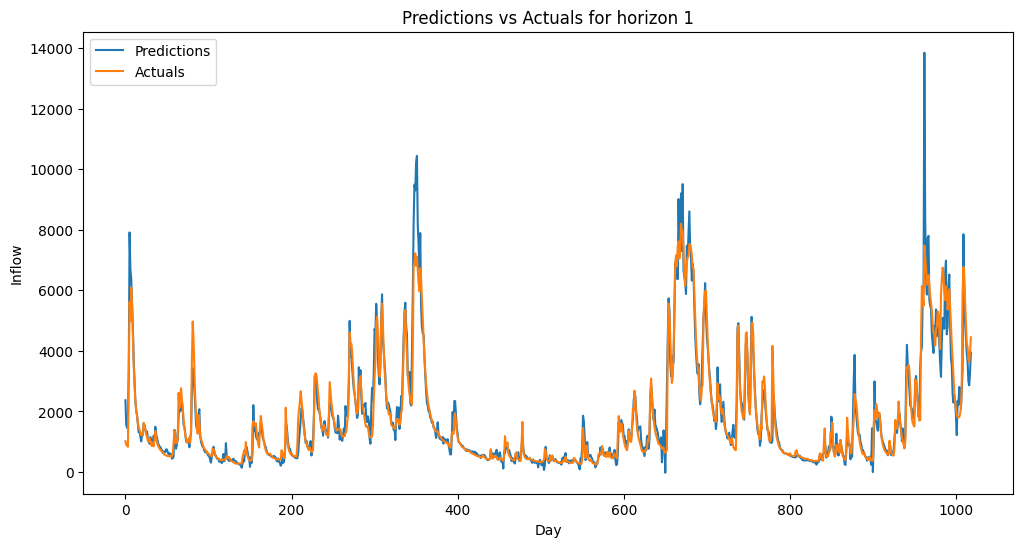

In [303]:
plt.figure(figsize=(12, 6))
plt.plot(post_processed_df['Day 1 Pred'], label='Predictions')
plt.plot(post_processed_df['Day 1 Actual'], label='Actuals')
plt.xlabel('Day')
plt.ylabel('Inflow')
plt.title("Predictions vs Actuals for horizon 1")
plt.legend()
plt.show()

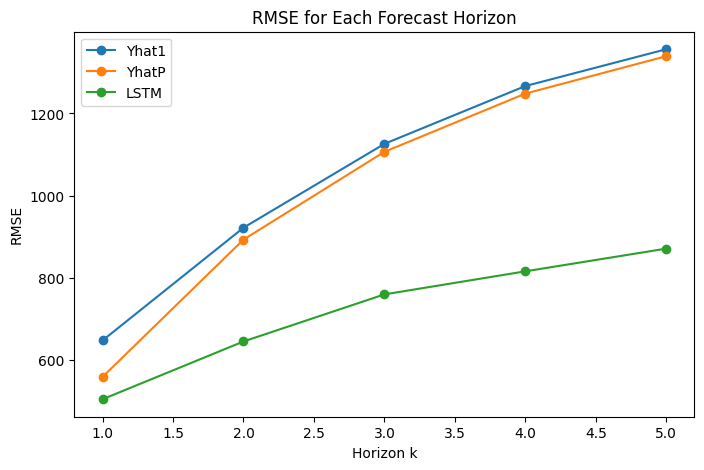

In [304]:
# Hard-coded RMSE values from R
rmse_yhat1 = [647.6976, 922.0222, 1126.1235, 1266.7477, 1356.4172]
rmse_yhatp = [559.0008, 893.0612, 1106.6746, 1248.3544, 1339.4242]

horizons = list(range(1,HORIZON+1))

# Plot each list with a line
plt.figure(figsize=(8, 5))
plt.plot(horizons, rmse_yhat1, marker='o', label='Yhat1')
plt.plot(horizons, rmse_yhatp, marker='o', label='YhatP')
plt.plot(horizons, rmse_values.values(), marker='o', label='LSTM')

plt.xlabel("Horizon k")
plt.ylabel("RMSE")
plt.title("RMSE for Each Forecast Horizon")
plt.legend()
plt.show()

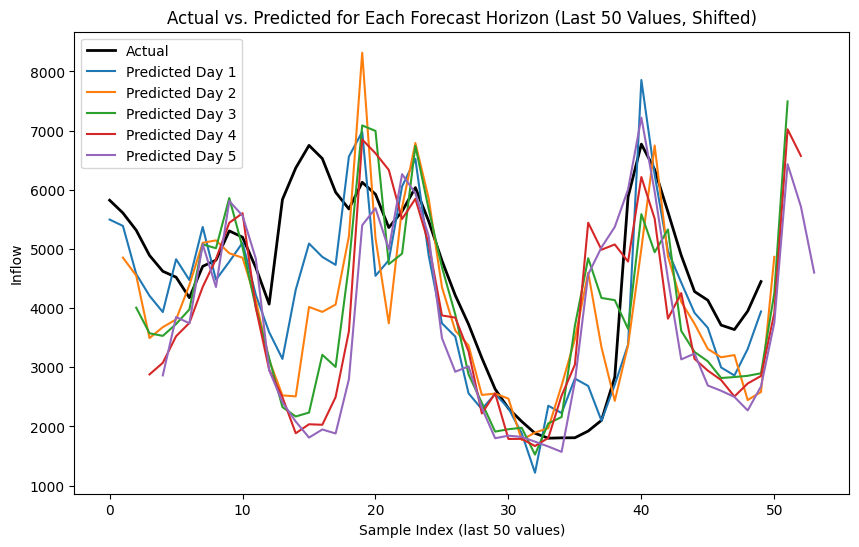

In [305]:
import numpy as np
import matplotlib.pyplot as plt

def plot_multi_horizon_single_actual_shifted(df, horizon=HORIZON, last_n=50):
    """
    Plots one actual line (since all horizons share the same actual values)
    and the predicted values for each forecast horizon on a single figure,
    using only the last 'last_n' samples, but SHIFTING each horizon's line
    so it aligns with the actual day it predicts.

    Assumes the DataFrame has:
      - An actual column named "Day 1 Actual"
      - Predicted columns for each horizon: "Day 1 Pred", "Day 2 Pred", ..., "Day k Pred"

    Parameters:
      df      : DataFrame with at least these columns
      horizon : Number of forecast days (e.g., 5)
      last_n  : How many of the final samples to plot
    """
    plt.figure(figsize=(10, 6))

    # We'll create an x-array for the "last_n" points
    # Day 1 predictions align at x, Day 2 at x+1, Day 3 at x+2, etc.
    x = np.arange(last_n)

    # Plot only the last 'last_n' samples of the actual values
    actual = df["Day 1 Actual"].tail(last_n).values
    plt.plot(x, actual, label="Actual", color="black", linewidth=2)

    # Plot each horizon with a horizontal shift of (i - 1)
    for i in range(1, horizon + 1):
        pred_col = f"Day {i} Pred"
        preds = df[pred_col].tail(last_n).values

        # Shift Day i's predictions by (i-1) steps
        x_shifted = x + (i - 1)
        plt.plot(x_shifted, preds, label=f"Predicted Day {i}")

    plt.xlabel(f"Sample Index (last {last_n} values)")
    plt.ylabel("Inflow")
    plt.title(f"Actual vs. Predicted for Each Forecast Horizon (Last {last_n} Values, Shifted)")
    plt.legend()
    plt.show()

# Example usage:
plot_multi_horizon_single_actual_shifted(post_processed_df, horizon=HORIZON, last_n=50)

